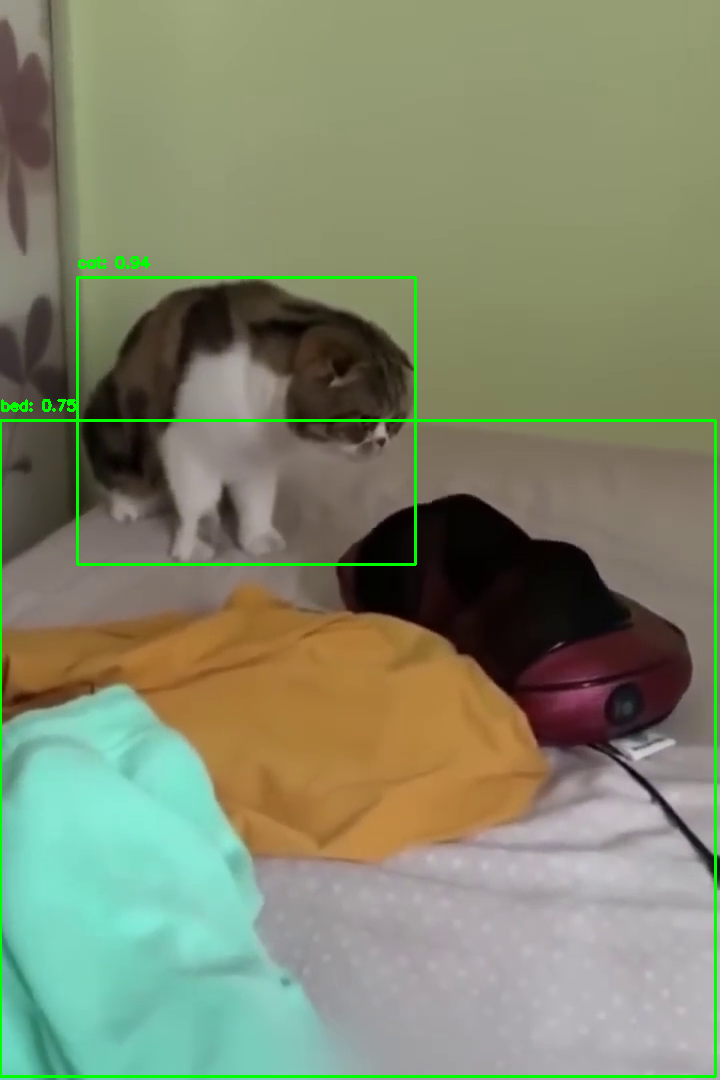

Predicted Action: Unknown



KeyboardInterrupt: 

In [7]:
from ultralytics import YOLO
import cv2
import numpy as np
import torch
from torchvision import models, transforms
from torchvision.models.video import R3D_18_Weights
from PIL import Image
from collections import deque
from IPython.display import display, clear_output

# Initialize YOLO and 3D-CNN models
def initialize_models():
    # Load the pretrained YOLOv8m model
    model_yolo = YOLO('yolov8m.pt')
    
    # Load a pre-trained 3D-CNN model for action recognition (e.g., ResNet3D-18)
    model_i3d = models.video.r3d_18(weights=R3D_18_Weights.DEFAULT)
    model_i3d.eval()
    
    return model_yolo, model_i3d

# Process frames for action recognition
def process_frames(frames, transform):
    """
    Prepare a batch of frames for the 3D-CNN action recognition model.
    """
    pil_images = [Image.fromarray(frame) for frame in frames]  # Convert to PIL Images
    batch = torch.stack([transform(frame) for frame in pil_images], dim=1)  # Shape: (3, 16, 112, 112)
    return batch.unsqueeze(0)  # Shape: (1, 3, 16, 112, 112)

# Draw YOLO detections on frames
def draw_detections(frame, results, model_yolo, confidence_threshold):
    """
    Draw detected objects on the frame.
    """
    annotated_frame = frame.copy()
    detected_objects = results[0].boxes.data.cpu().numpy()  # Get detected boxes

    for obj in detected_objects:
        confidence = obj[4]
        if confidence >= confidence_threshold:
            class_id = int(obj[5])
            object_name = model_yolo.names[class_id]
            x1, y1, x2, y2 = int(obj[0]), int(obj[1]), int(obj[2]), int(obj[3])

            # Draw bounding box and label
            cv2.rectangle(annotated_frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            label = f"{object_name}: {confidence:.2f}"
            cv2.putText(annotated_frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
            print(f"Detected: {object_name} with confidence {confidence:.2f}")

    return annotated_frame

# Display frames in Jupyter Notebook
def display_frame(frame):
    """
    Display the frame in the Jupyter Notebook.
    """
    pil_image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    clear_output(wait=True)  # Clear the previous frame
    display(pil_image)

# Main video processing loop
def main():
    model_yolo, model_i3d = initialize_models()

    # Action labels for action recognition
    action_labels = {0: 'fighting', 1: 'running', 2: 'stealing'}  # Example action classes

    # Video source and settings
    video_source = "Cat_Dog_video.mp4"  # Replace with your video source
    cap = cv2.VideoCapture(video_source)
    confidence_threshold = 0.5
    frame_sequence = deque(maxlen=16)
    
    transform = transforms.Compose([
        transforms.Resize((112, 112)),
        transforms.ToTensor()
    ])

    try:
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                print("End of video stream or error.")
                break

            # YOLO detection on the current frame
            results = model_yolo(frame)

            # Draw detections and display frame
            annotated_frame = draw_detections(frame, results, model_yolo, confidence_threshold)
            display_frame(annotated_frame)

            # Prepare frames for 3D-CNN model
            rgb_frame = cv2.cvtColor(cv2.resize(frame, (112, 112)), cv2.COLOR_BGR2RGB)
            frame_sequence.append(rgb_frame)

            if len(frame_sequence) == 16:
                # Process frames for action recognition
                input_batch = process_frames(list(frame_sequence), transform)

                # Predict actions using 3D-CNN
                with torch.no_grad():
                    action_scores = model_i3d(input_batch)
                predicted_action = torch.argmax(action_scores, dim=1).item()
                print(f"Predicted Action: {action_labels.get(predicted_action, 'Unknown')}")

                frame_sequence.clear()

            cv2.waitKey(1)

    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        cap.release()

# Run the main loop
if __name__ == "__main__":
    main()
